<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/varying_number_of_channels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasks:

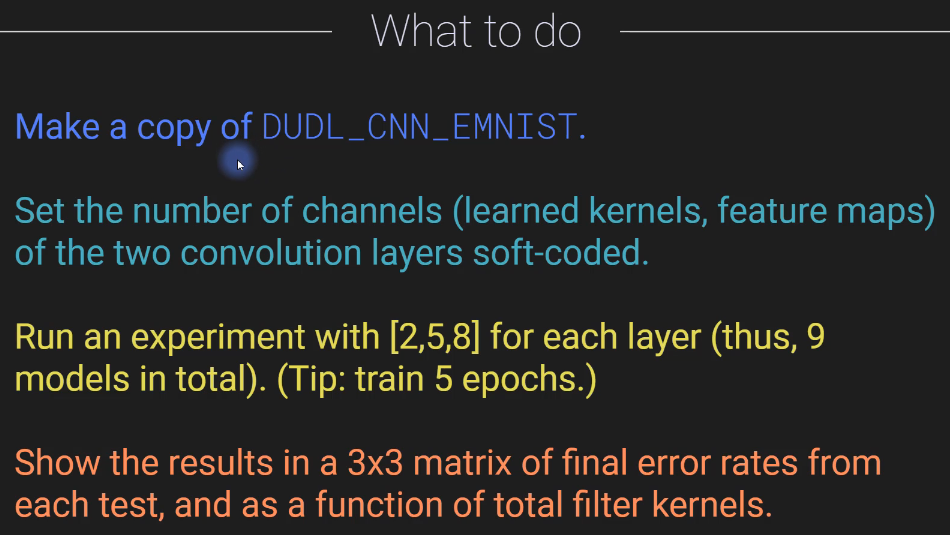

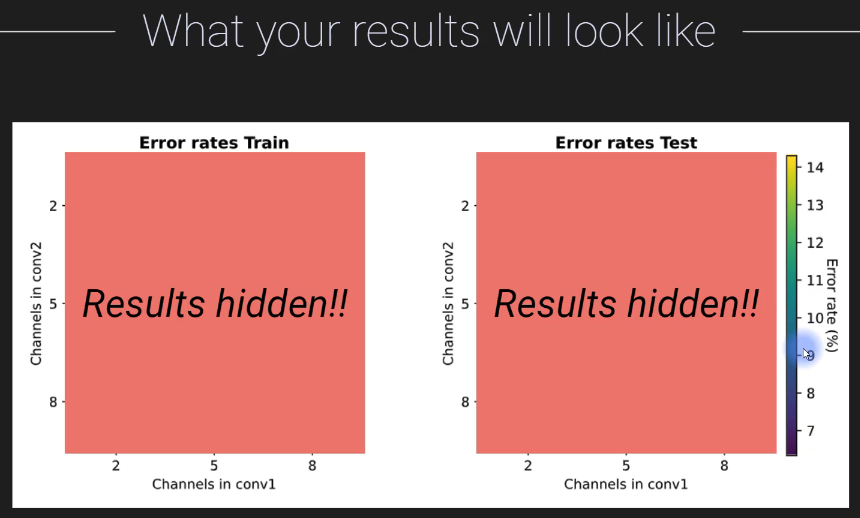

In [22]:
import torchvision # for importing data
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import copy # for making deep copies

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [23]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [24]:
device

device(type='cuda', index=0)

# Download & inspect the data:

In [25]:
# download the dataset: https://www.nist.gov/itl/products-and-services/emnist-dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

In [26]:
# inspect the data:

# print categories
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

# print data size
print('\nData size:')
print(cdata.data.shape)

# reshape to 4D tensor for conv layers & transform from int8 to float
images = cdata.data.view([124800,1,28,28]).float() # (imgs, channels, W, H), 1 channel (grayscale image)
print('\n4D Tensor size:')
print(images.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

4D Tensor size:
torch.Size([124800, 1, 28, 28])


In [27]:
# eliminate the 'N/A' label & subtract 1 from all other labels:

# remove the 'N/A' class (the 1st class category)
letterCategories = cdata.classes[1:]

# relabel the rest labels to start at 0 (make a deepcopy)
labels = copy.deepcopy(cdata.targets)-1 # cdata.targets is a list

In [28]:
# use scikitlearn to split both images and labels
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.1)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

# torch tensor -> torch Dataset obj (combine)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# torch Dataset obj -> torch DataLoader obj (shuffle)
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([112320, 1, 28, 28]) torch.Size([12480, 1, 28, 28]) torch.Size([112320]) torch.Size([12480])


# Create the DL model:

In [29]:
# create a class for the model
def makeTheNet(numchans=(6,6)): # (default) 6 feature maps in the 1st convolution layer & 6 feature maps in the 2nd convolutional layer

  class emnistnet(nn.Module):
    def __init__(self,numchans):
      super().__init__()

      ### -------------- feature map layers --------------

      # first convolution layer
      self.conv1  = nn.Conv2d(1,numchans[0],3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(numchans[0])

      # second convolution layer
      self.conv2  = nn.Conv2d(numchans[0],numchans[1],3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(numchans[1])


      ### -------------- linear decision layers --------------

      self.fc1 = nn.Linear(7*7*numchans[1],50)
      self.fc2 = nn.Linear(50,26)

    def forward(self,x):

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)

      return x

  # create the model instance
  net = emnistnet(numchans)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [30]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet((6,12))

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape, "\n")

# compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print('loss:', loss)


Output size:
torch.Size([32, 26]) 

loss: tensor(3.2739, grad_fn=<NllLossBackward0>)


# Create a function to train the model:

In [31]:
# a function that trains the model

def function2trainTheModel(numchans):

  # number of epochs
  numepochs = 5

  # create a new model
  net,lossfun,optimizer = makeTheNet(numchans)

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):
    net.train()
    batchLoss = []
    batchErr  = []

    # loop over training data batches
    for X,y in train_loader:
      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error rate from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)

    # test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # extract loss and error rates for test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

# Train the model & show the results:

In [32]:
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel((3,7))

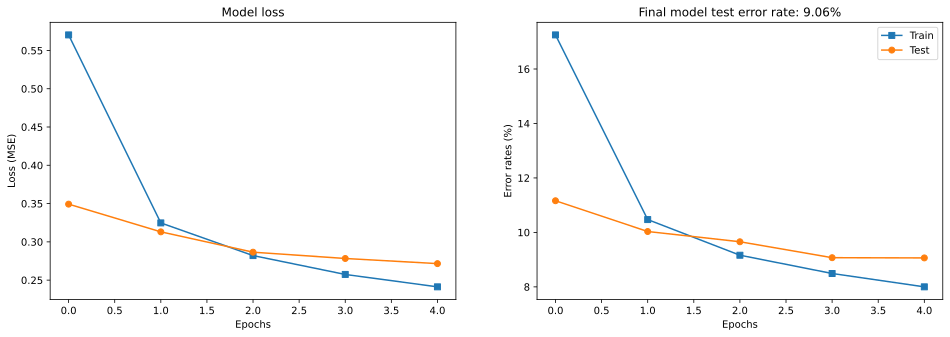

In [33]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

# Experiment:

In [34]:
# this experiment takes ~8 mins on a GPU
convChans = [2,5,8]

# initialize results matrix
results    = np.zeros((len(convChans),len(convChans),2)) # 2: trainErr, testErr
convParams = np.zeros((len(convChans),len(convChans)))

for i,Nchani in enumerate(convChans):
  for j,Nchanj in enumerate(convChans):

    # run the model
    trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel((Nchani,Nchanj))

    # get results
    results[i,j,:]  = trainErr[-1],testErr[-1]
    convParams[i,j] = Nchani+Nchanj # total number of convolution layer channels

    print(i,j)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


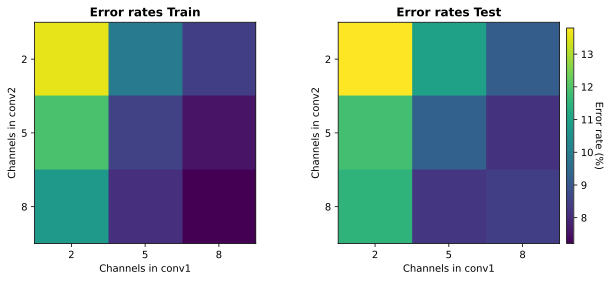

In [35]:
# Show the results matrix

fig,ax = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
  h = ax[i].imshow(results[:,:,i],vmin=np.min(results),vmax=np.max(results))
  ax[i].set_xlabel('Channels in conv1')
  ax[i].set_ylabel('Channels in conv2')
  ax[i].set_xticks(range(j+1)) # j defined in previous cell
  ax[i].set_yticks(range(j+1))
  ax[i].set_xticklabels(convChans)
  ax[i].set_yticklabels(convChans)
  title = 'Train' if i==0 else 'Test'
  ax[i].set_title('Error rates %s'%title,fontweight='bold')


# add a colorbar right of the plot (use common colorscaling for both plots)
axpos = ax[1].get_position()
cax = fig.add_axes([axpos.x1+.01,axpos.y0,.01,.75])
hh = fig.colorbar(h,cax=cax)
hh.set_label('Error rate (%)',rotation=270,labelpad=10)

plt.show()

👆 The more channels we add, the colors go from yellow to green to blue, which means the error rate is going down.

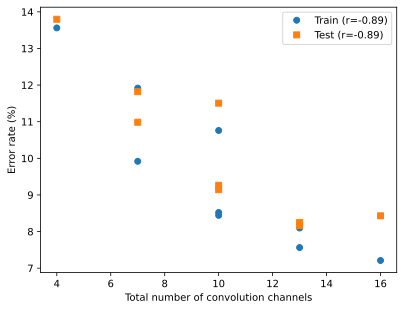

In [36]:
# error rate as a function of the total number of conv channels

corrTrain = np.corrcoef(convParams.flatten(),results[:,:,0].flatten()) # 0 for train
corrTest  = np.corrcoef(convParams.flatten(),results[:,:,1].flatten()) # 1 for test

# plots
plt.plot(convParams.flatten(),results[:,:,0].flatten(),'o',
         label=f'Train (r={corrTrain[0,1]:.2f})') # grab off diagonal elmts
plt.plot(convParams.flatten(),results[:,:,1].flatten(),'s',
         label=f'Test (r={corrTest[0,1]:.2f})')

# other stuff etc
plt.legend()
plt.xlabel('Total number of convolution channels')
plt.ylabel('Error rate (%)')
plt.show()

👆 The more convolution channels (filters) we have, the better the overall performance (ower error rates).